## 목표
---
1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?

ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.


2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?

CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.


3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?

CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.


## STEP 0. 라이브러리 로드
---


In [16]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

## STEP 1. 데이터 로드
---

In [3]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True)

train data를 만들어줍니다

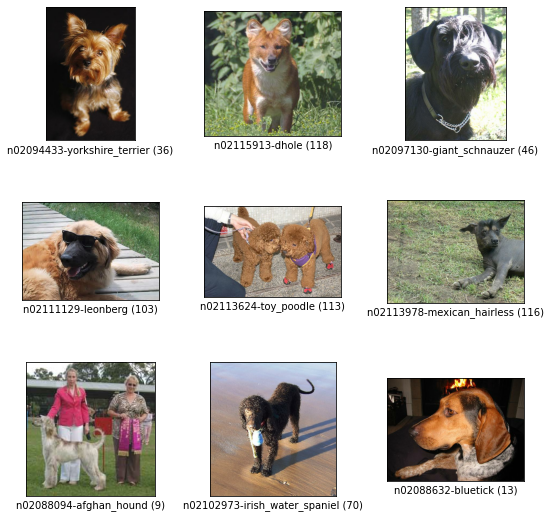

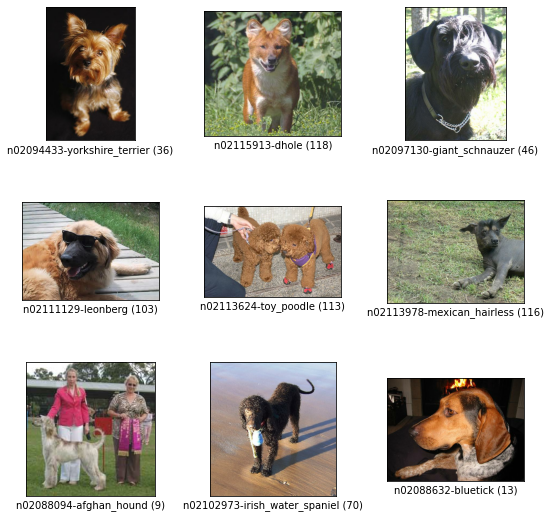

In [4]:
tfds.show_examples(ds_train, ds_info)

test data도 마찬가지로 준비합니다!

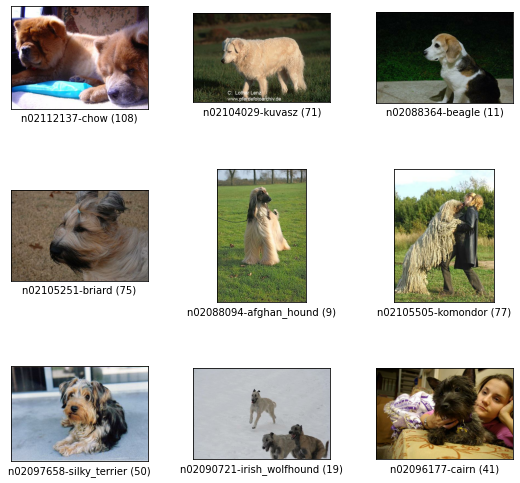

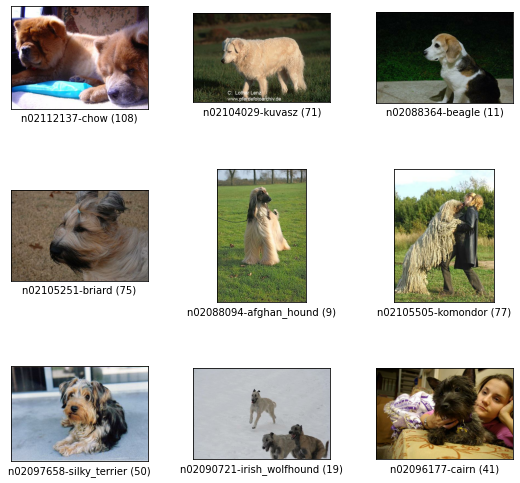

In [5]:
tfds.show_examples(ds_test, ds_info)

꼭 확인해야하는 info도 놓치면 안됩니당!

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

데이터를 모델에 넣을 준비까지 해줍니다.

In [8]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [9]:
def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16):
    ds = ds.map(normalize_and_resize_img,
               num_parallel_calls = 2)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm  = apply_normalize_on_dataset(ds_test)

# 배치모양 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


## STEP 2. 모델 학습
---
오늘의 주제는 CAM이기 때문에 따로 모델을 만들지 않고 만들어진 ResNet 50 모델을 불러옵니다.  

또한 학습은 Grad-CAM, CAM용모델로 학습할 겁니다.

### 2.1 모델 불러오기
---

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(include_top = False,     # Imagenet 분류기  fully connected layer 제거
                                                  weights     = 'imagenet',
                                                  input_shape = (224, 224,3),
                                                  pooling     = 'avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x) # 마지막 softmax 적용
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

### 2.2  모델학습 - Plain (LMS)

In [11]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate= 0.01),
    metrics=['accuracy'])

In [13]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
history_cam_model = cam_model.fit(ds_train_norm,
                                  steps_per_epoch     = int(ds_info.splits['train'].num_examples / 16),
                                  validation_steps    = int(ds_info.splits['test'].num_examples / 16),
                                  epochs              = 5,
                                  validation_data     = ds_test_norm,
                                  verbose             = 1,
                                  use_multiprocessing = True,)

Epoch 1/5
750/750 [==============================] - 174s 219ms/step - loss: 1.3604 - accuracy: 0.6318 - val_loss: 1.7880 - val_accuracy: 0.5096
Epoch 2/5
750/750 [==============================] - 157s 210ms/step - loss: 0.5834 - accuracy: 0.8395 - val_loss: 1.0969 - val_accuracy: 0.6803
Epoch 3/5
750/750 [==============================] - 157s 209ms/step - loss: 0.1864 - accuracy: 0.9629 - val_loss: 1.0235 - val_accuracy: 0.7032
Epoch 4/5
750/750 [==============================] - 157s 209ms/step - loss: 0.0552 - accuracy: 0.9947 - val_loss: 0.9235 - val_accuracy: 0.7316
Epoch 5/5
750/750 [==============================] - 157s 209ms/step - loss: 0.0254 - accuracy: 0.9986 - val_loss: 0.9117 - val_accuracy: 0.7418


In [17]:
# 학습 모델 저장
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


저장 완료!


잘 학습을 했는지, 학습된 모델을 시각화 해봅니당.

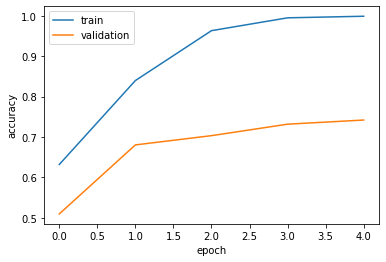

In [21]:
plt.plot(history_cam_model.history['accuracy'], label ='train')
plt.plot(history_cam_model.history['val_accuracy'], label ='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='upper left')
plt.show()

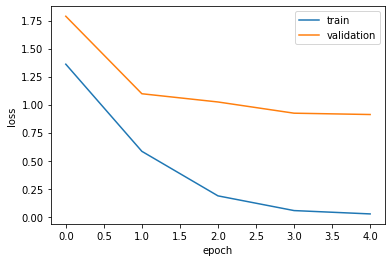

In [19]:
plt.plot(history_cam_model.history['loss'], label ='train')
plt.plot(history_cam_model.history['val_loss'], label ='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

## STEP 3. CAM 구현하기
---
이제 모델이 어딜 참고했는지 확인하는 작업을 진행해봅니다.   
CAM 값과 Origin 사진을 합쳐 한눈에 볼 예정입니다!

In [22]:
# 확인용 사진 1장 뽑는 함수
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

108


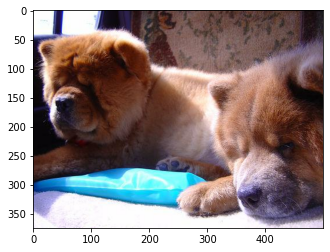

In [23]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

혹시 모를 나중을 위한 학습 모델 로드 코드도 추가해줍니다.

In [24]:
# cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
# cam_model = tf.keras.models.load_model(cam_model_path)
# print('모델 로드 완료')

CAM을 생성하기 위해서는   
(1) 특성 맵   
(2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치   
(3) 원하는 클래스의 출력값   

이 필요합니다.   


또한 사진에 오버랩하기 위해선 생성된 CAM의 사이즈를 원본과 맞춰주는 작업도 필요합니다.
관련 함수를 만들어줍니다!

In [25]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있다고합니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타납니다
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

위의 함수를 합치면 이제 CAM을 불러낼 준비가 끝났습니다.   
확인해보죠

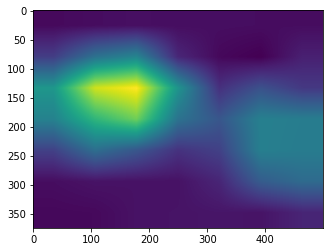

In [26]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

이제 원본 이미지와 합쳐봅니다.

In [27]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

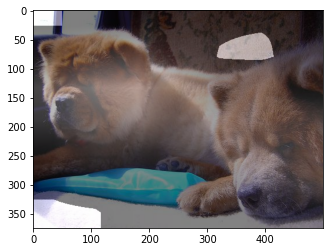

In [28]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

주로 얼굴과 몸통 부분이 강조된 것이 보인다. 

생각해보면 우리도 개를 개로 인식하기 위해 주로 얼굴부분과 몸통을 통해 확인하는데 이와 비슷하다고 생각된다. 

## STEP 4.  Grad-CAM
---
이번엔 Grad-CAM을 통해 CAM을 얻어봅니다. 
 Grad-CAM은 모델을 유연하게 선택할 수 있으니 위에서 학습한 모델로 사용합니다.

67


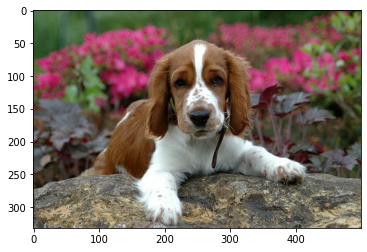

In [29]:
# 이미지 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

Grad-CAM을 이용한 CAM 뽑기

In [30]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

### 4.1 레이어별 grad CAM 확인
---

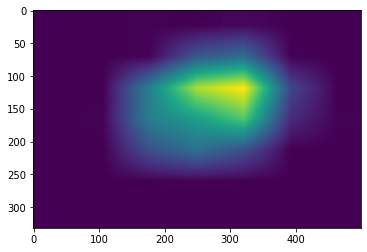

In [31]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

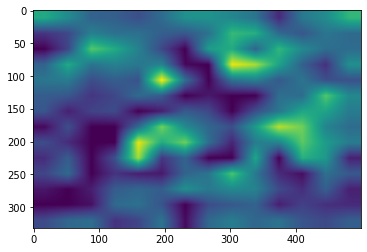

In [32]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

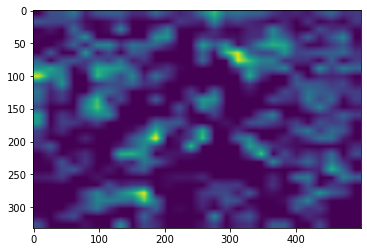

In [33]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## STEP 5. Detection with CAM

### 5.1 Bounding Box
---
마지막으로 CAM에서 물체의 위치를 찾는 detection을 해봅니다.

우선 새로운 이미지를 다시 뽑아 CAM 이미지를 뽑아봅시다.

100


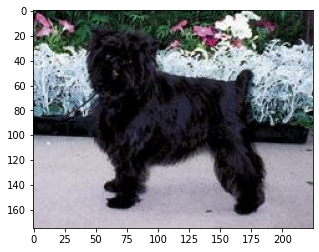

In [34]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

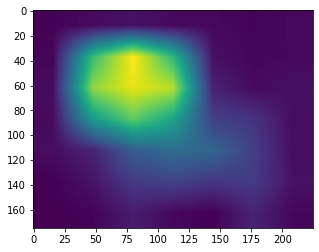

In [35]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [36]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

시각화!

In [37]:
rect = get_bbox(cam_image)
rect

array([[ 17,  13],
       [206,  13],
       [206, 174],
       [ 17, 174]])

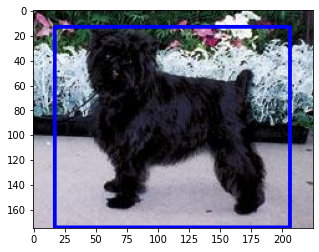

In [38]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### 5.2 Intersection Over Union
---
앞에서도 물체의 detecting 정확도를 확인하기 위해 IoU를 사용했었는데, 여기서도 IoU를 사용해 확인합니다.

rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 

In [39]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [40]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.07428571428571429,
 0.07555555555555556,
 0.9942857142857143,
 0.9155555555555556]

In [41]:
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [42]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [43]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7592757111010343